In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text as alchemy_text
from mpl_toolkits.basemap import Basemap
import warnings
from scipy.spatial import ConvexHull
from scipy import ndimage
from scipy.spatial.distance import cdist
warnings.filterwarnings('ignore')
print ("Load completed...")

Load complete...


In [48]:
num_clusters = 10 #10
st_dev = 1 #1 for ebma, 2 for average
percentile = 90 #90 for ebma, 50 for average
varname = 'ebma' #ebma or sb_average
tname = 'sb_ebma_eval_PGM_04' #table name
month = 456 #430

In [49]:
db_engine_name = 'postgresql://VIEWSADMIN@VIEWSHOST:5432/views'

query = alchemy_text (
'''
with a as (
    SELECT
      pg_id,'''+varname+'''
    FROM landed."'''+tname+'''"
    WHERE month_id = '''+str(month)+'''
          AND '''+varname+''' > (SELECT avg('''+varname+''') + stddev('''+varname+''') * '''+str(st_dev)+'''
                      FROM landed."'''+tname+'''")
)
SELECT latitude,longitude FROM staging.priogrid
WHERE
gid IN (SELECT pg_id FROM a)
'''
)

In [50]:
engine = create_engine(db_engine_name)
with engine.connect() as con:
    pdX = pd.read_sql(sql=query, con=con)
pdX.shape

(203, 2)

In [51]:
X=np.array(pdX)
X[0:10]

array([[ 10.25,  12.25],
       [ 11.75,  14.25],
       [ 10.75,  13.25],
       [  6.75,  44.25],
       [  1.75,  44.25],
       [  2.75,  41.25],
       [  9.75,   8.75],
       [  3.25,  41.75],
       [ 12.25,  13.25],
       [-26.25,  27.75]])

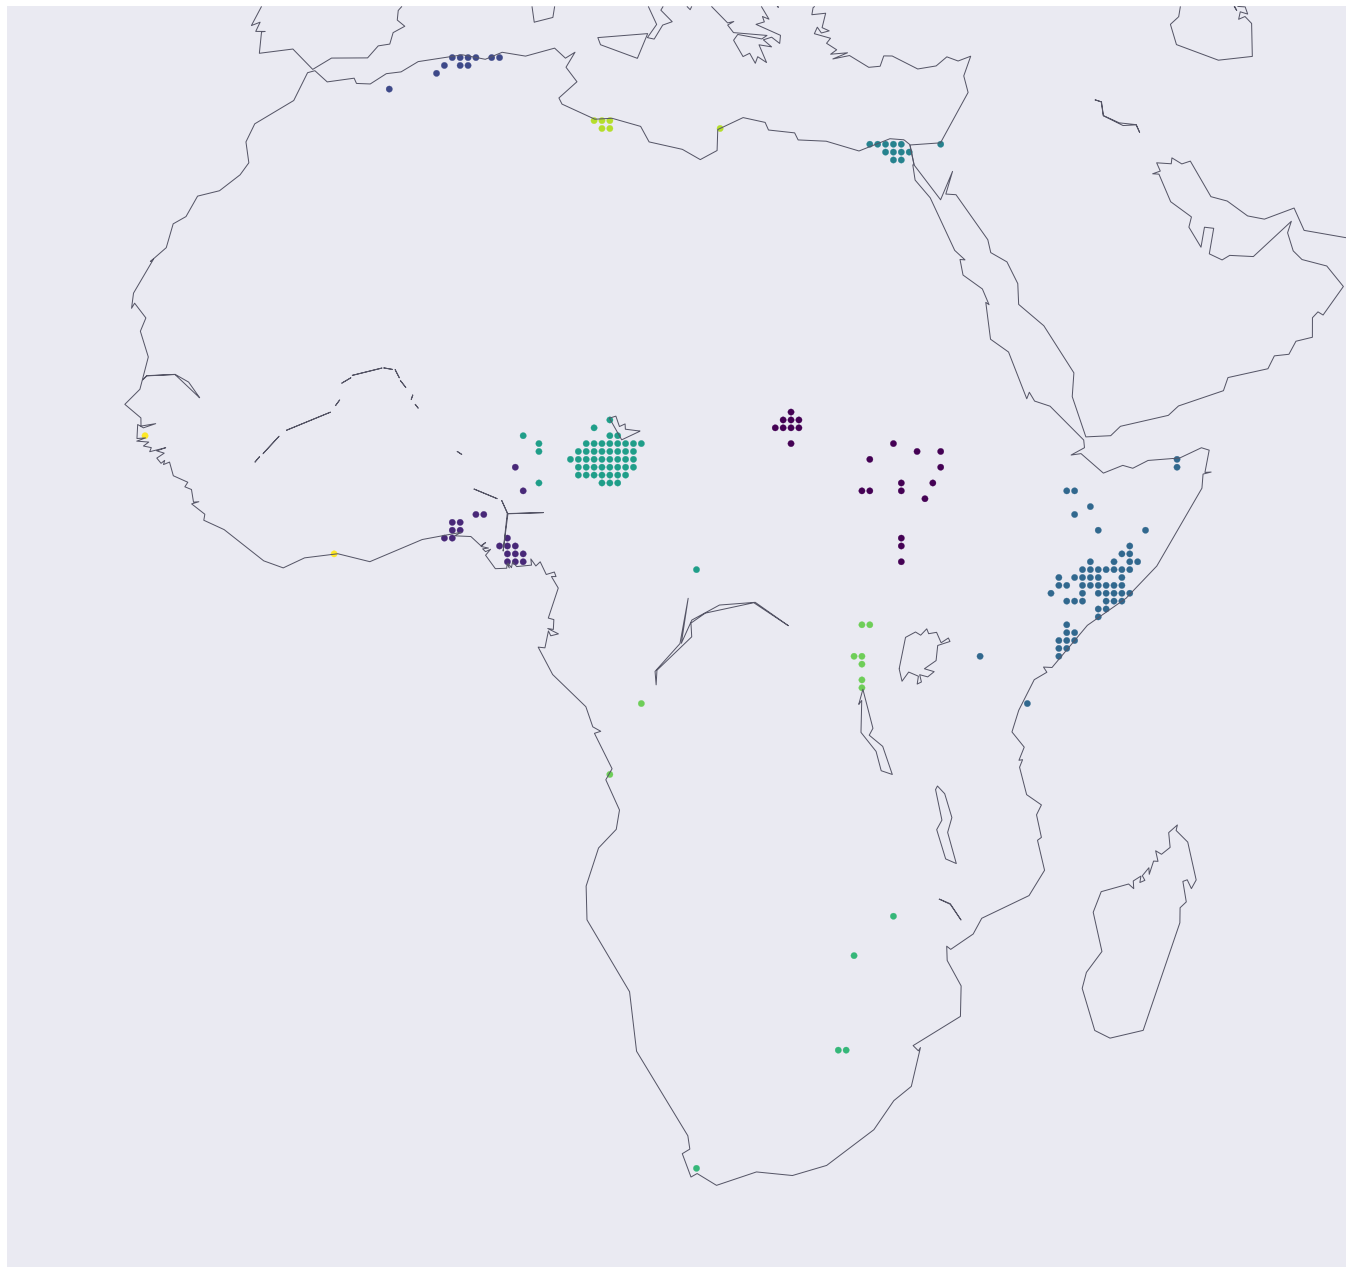

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(num_clusters, random_state=0)
labels = kmeans.fit(X).predict(X)
earth = Basemap(projection='cyl',llcrnrlat=-40,urcrnrlat=40,\
            llcrnrlon=-25,urcrnrlon=+60,resolution='c')

plt.figure(figsize=(24, 24))

#earth.bluemarble(alpha=0.42)
earth.drawcoastlines(color='#555566', linewidth=1)

plt.scatter(X[:, 1], X[:, 0], c=labels, s=40, cmap='viridis')

centers = kmeans.cluster_centers_
radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]


*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************


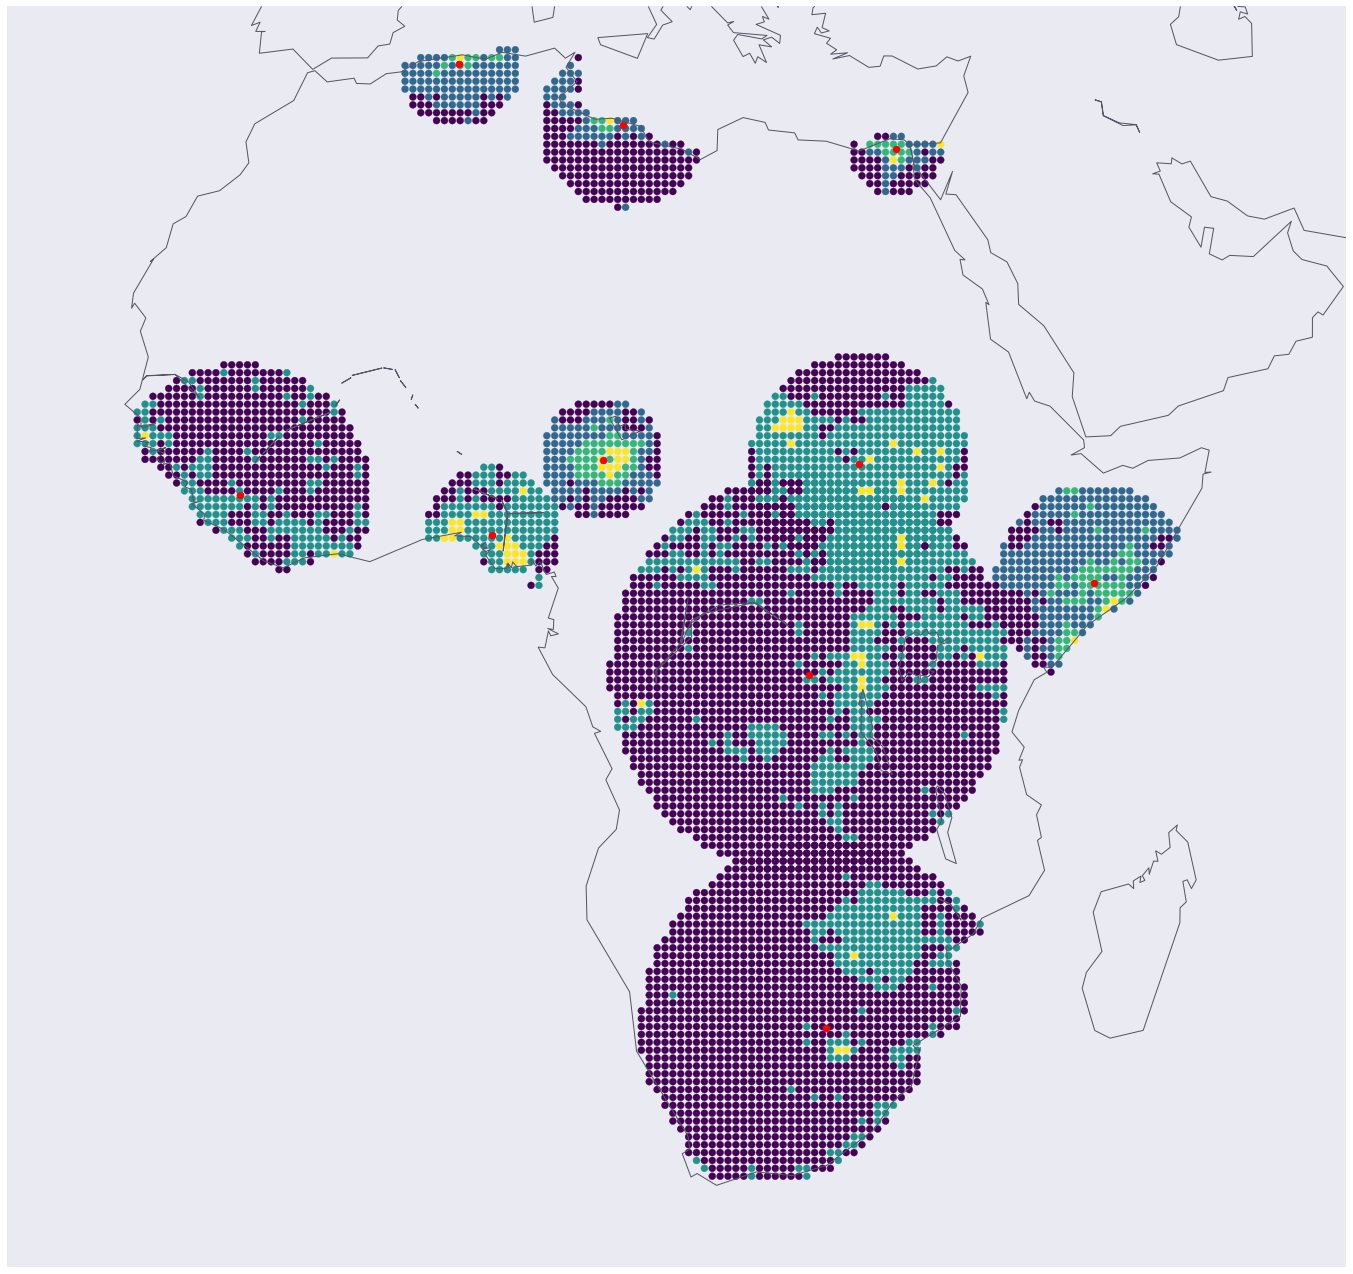

In [53]:

Y=np.dstack([X[:,0],X[:,1],labels])[0]
earth = Basemap(projection='cyl',llcrnrlat=-40,urcrnrlat=40,\
            llcrnrlon=-25,urcrnrlon=+60,resolution='c')

plt.figure(figsize=(24, 24))

#earth.bluemarble(alpha=0.42)
earth.drawcoastlines(color='#555566', linewidth=1)
#plt.scatter(X[:, 1], X[:, 0], c=labels, s=40, cmap='viridis')

cmassA=[]

for i in range(0,num_clusters):
    convex_hull = Y[Y[:,2]==i]
    convex_hull = np.dstack((convex_hull[:,0],convex_hull[:,1]))[0]
    #hull = ConvexHull(convex_hull)
    
    # Compute the center of mass
    cmass = np.average(convex_hull, axis=0)
    #print (cmass)
    plt.scatter(cmass[1],cmass[0], c='red', cmap='viridis')
    cmassA.append(cmass)

    # Compute the average distance from each point in the bucket to the center of mass
    dist = cdist(convex_hull,np.array([cmass]))
    #print (dist)
    print ("*"*25)
    
    # Elimitate outliers (defined as points with a distance at above 90% percentile). Add 2 cell (1 decdegree buffer)
    r = np.percentile(dist,percentile) + 1
    
    # Grab all the priogrid cells that would fit the center of mass and buffer
    query = alchemy_text('''
    with a as (
    SELECT
      gid,
      latitude,
      longitude
    FROM staging.priogrid
    WHERE
      ST_Intersects(ST_Buffer(st_setsrid(ST_Point(:lon, :lat), 4326), :radius), geom)
)
SELECT a.latitude, a.longitude, log(1+e.'''+varname+'''*10000)::int as xval FROM  landed."'''+tname+'''" e, a 
WHERE a.gid=e.pg_id AND e.month_id='''+str(month)+'''
    ''')
    query = query.bindparams(lon=cmass[1],lat=cmass[0],radius=r)
    engine = create_engine(db_engine_name)
    
    with engine.connect() as con:
        plotCells = pd.read_sql(sql=query, con=con)
        #print(plotCells.xval)
        NX = np.array(plotCells[['latitude','longitude']])
        
        #print(labels)
        plt.scatter(NX[:, 1], NX[:, 0], c=plotCells.xval, cmap='viridis')
    
    #plt.scatter(cmass[1],cmass[0], c='red', cmap='viridis')
    
for cmass in cmassA:
    plt.scatter(cmass[1],cmass[0], c='red')


In [15]:
print("Done")

Done
